In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import pandas as pd

df = pd.read_csv('spam.csv')
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
747/4825

0.15481865284974095

In [7]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [8]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [10]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [14]:
df_balanced = pd.concat([df_spam, df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [15]:
df_balanced['Category'].value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

In [17]:
df_balanced.sample(5)

,Category,Message
5053,ham,"Tick, tick, tick .... Where are you ? I could ..."
2363,ham,How are you doing? Hope you've settled in for ...
1414,spam,Dear U've been invited to XCHAT. This is our f...
2070,spam,"Eerie Nokia tones 4u, rply TONE TITLE to 8007 ..."
2269,spam,88066 FROM 88066 LOST 3POUND HELP


In [22]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
1853,spam,This is the 2nd time we have tried 2 contact u...,1
1324,ham,I thk 50 shd be ok he said plus minus 10.. Did...,0
1574,spam,SMS AUCTION - A BRAND NEW Nokia 7250 is up 4 a...,1
136,ham,I only haf msn. It's yijue@hotmail.com,0
515,spam,"You are guaranteed the latest Nokia Phone, a 4...",1


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify=df_balanced['spam'])

In [24]:
X_train.head(4)

4061    This weeks SavaMob member offers are now acces...
3189    This is the 2nd time we have tried 2 contact u...
4205    How are you enjoying this semester? Take care ...
3657    Oh really?? Did you make it on air? What's you...
Name: Message, dtype: object

In [25]:
bert_preprocess = hub.KerasLayer('https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3')
bert_encoder = hub.KerasLayer('https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-12-h-768-a-12/2')

In [26]:
def get_sentence_embeding(sentences):

    preprocess_text = bert_preprocess(sentences)
    return bert_encoder(preprocess_text)['pooled_output']

get_sentence_embeding([
                '500$ discount. hurry up', 
                'Arief, are you up for a volleyball game tomorrow'])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[ 0.07341201, -0.24231917,  0.77544093, ..., -0.77660024,
         0.374001  ,  0.9943133 ],
       [ 0.10854592, -0.10986909,  0.26949918, ..., -0.5972112 ,
         0.23296183,  0.99663883]], dtype=float32)>

In [27]:
e = get_sentence_embeding([
    'banana',
    'grapes',
    'mango',
    'jeff bezos',
    'elon musk',
    'bill gates'
])

In [28]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[ 0.2669101 , -0.19130918,  0.08401512, ..., -0.6186055 ,
         0.00352731,  0.9997841 ],
       [ 0.36021137,  0.1410067 ,  0.91185534, ..., -0.90020543,
        -0.11662497,  0.999294  ],
       [ 0.2480219 , -0.2330336 ,  0.54398286, ..., -0.42076838,
         0.34572062,  0.9984345 ],
       [ 0.38130066,  0.28613928,  0.9919579 , ..., -0.7382513 ,
         0.09307909,  0.9923761 ],
       [-0.11932132, -0.5508697 ,  0.97181344, ..., -0.8815351 ,
         0.6638505 ,  0.97706765],
       [-0.19683628, -0.1419294 ,  0.9962836 , ..., -0.92230564,
         0.3488089 ,  0.9663725 ]], dtype=float32)>

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[3]], [e[4]])

array([[0.62914324]], dtype=float32)

In [34]:
#bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#Neural network layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# construct final model 
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [35]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [38]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [39]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 22s 448ms/step - loss: 0.5919 - accuracy: 0.7268 - precision: 0.7082 - recall: 0.7714
Epoch 2/10
35/35 [==============================] - 7s 188ms/step - loss: 0.3845 - accuracy: 0.9000 - precision: 0.8784 - recall: 0.9286
Epoch 3/10
35/35 [==============================] - 7s 192ms/step - loss: 0.2925 - accuracy: 0.9286 - precision: 0.9124 - recall: 0.9482
Epoch 4/10
35/35 [==============================] - 7s 192ms/step - loss: 0.2458 - accuracy: 0.9402 - precision: 0.9214 - recall: 0.9625
Epoch 5/10
35/35 [==============================] - 7s 194ms/step - loss: 0.2117 - accuracy: 0.9527 - precision: 0.9455 - recall: 0.9607
Epoch 6/10
35/35 [==============================] - 7s 190ms/step - loss: 0.1937 - accuracy: 0.9545 - precision: 0.9504 - recall: 0.9589
Epoch 7/10
35/35 [==============================] - 7s 191ms/step - loss: 0.1836 - accuracy: 0.9518 - precision: 0.9470 - recall: 0.9571
Epoch 8/10
35/35 [======================

In [40]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 4s 186ms/step - loss: 0.1548 - accuracy: 0.9652 - precision: 0.9531 - recall: 0.9786


[0.15484407544136047, 0.9652406573295593, 0.953125, 0.9786096215248108]

In [41]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [43]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [45]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[178,   9],
       [  4, 183]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

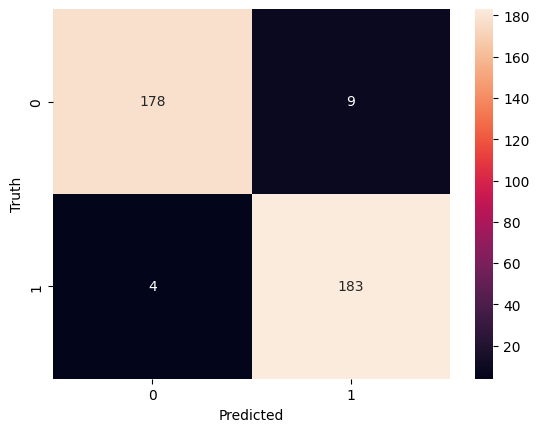

In [47]:
import matplotlib.pyplot as plt
import seaborn as sn 

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [50]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       187
           1       0.95      0.98      0.97       187

    accuracy                           0.97       374
   macro avg       0.97      0.97      0.97       374
weighted avg       0.97      0.97      0.97       374



In [51]:
reviews = [
    'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.9596463 ],
       [0.98985744],
       [0.9565738 ],
       [0.0801435 ],
       [0.05400895]], dtype=float32)